In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from pytorch_lightning import Trainer

from matplotlib import pyplot as plt

from datasets import Faces
from vanilla_ae import VanillaAE
from vae import VAE
from cvae import VAE as CVAE



# Image morphing

In [3]:
input_shape = (3, 32, 32)
model = VanillaAE(input_shape, dataset_name='faces')
trainer = Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 786 K 
1 | decoder | Decoder | 789 K 


1

In [11]:
model.eval()

transforms_ = transforms.Compose([transforms.ToTensor()])
dataset = Faces('images/faces/', transforms_=transforms_, img_height=input_shape[1], img_width=input_shape[2])

In [24]:
img1 = dataset[0][0].view(1, *(img1.shape)).to('cuda')
img2 = dataset[-1][0].view(1, *(img2.shape)).to('cuda')
latent_vector_1 = model.encoder(img1)
latent_vector_2 = model.encoder(img2)
alphas = np.linspace(0, 1, 9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


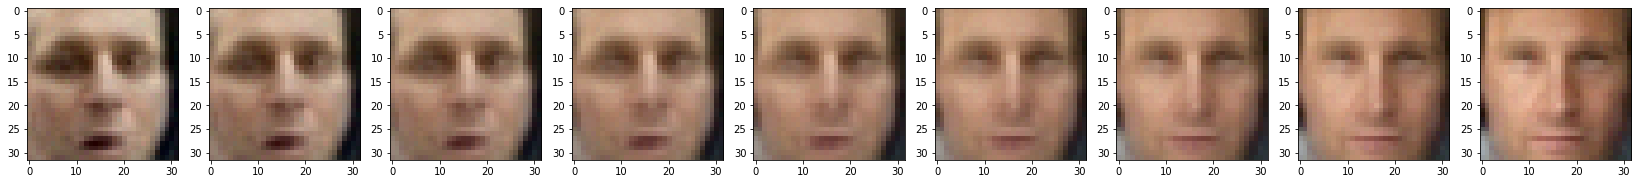

In [48]:
fig = plt.figure(figsize=(32, 32))  # width, height in inches
for i in range(9):
    alpha = alphas[i]
    rec_image = model.decoder(alpha*latent_vector_1 + (1 - alpha)*latent_vector_2).permute(0, 2, 3, 1).detach().cpu().numpy()    
    sub = fig.add_subplot(1, 10, i + 1)
    sub.imshow(rec_image[0], interpolation='nearest')

# Denoising

In [84]:
class AddGaussianNoise(object):
    def __init__(self, noise_factor=0.5, mean=0., std=1.):
        self.std = std
        self.mean = mean
        self.noise_factor = noise_factor
        
    def __call__(self, tensor):
        return tensor + self.noise_factor*(torch.randn(tensor.size()) * self.std + self.mean).to('cuda')
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, noise={2})'.format(self.mean, self.std, self.noise_factor)

class DenoisingAE(VanillaAE):
    def __init__(self, input_shape, net_type='fc', dataset_name='mnist'):
        super().__init__(input_shape, net_type, dataset_name)
        self.noise = AddGaussianNoise(0.5, 0, 1)
        
    def training_step(self, batch, batch_idx):
        images, _ = batch
        noisy_images = self.noise(images)
        _, rec_images = self(noisy_images)  
        loss = torch.nn.functional.mse_loss(rec_images, images)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        images, _ = batch
        noisy_images = self.noise(images)
        _, rec_images = self(noisy_images)
        loss = torch.nn.functional.mse_loss(rec_images, images)
      
        self.last_images = noisy_images[:5]
        self.generated_images = rec_images[:5]

        return {'val_loss': loss}

In [85]:
input_shape = (3, 32, 32)
denoising_model = DenoisingAE(input_shape, dataset_name='faces')
trainer = Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


#### Visualizing
You can launch this to see, how does model recover images from val dataset while training.

In [72]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16160), started 8:57:14 ago. (Use '!kill 16160' to kill it.)

In [86]:
trainer.fit(denoising_model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 786 K 
1 | decoder | Decoder | 789 K 


1

If you don't want to run it manually: some results.

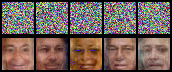
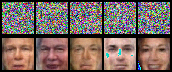

# Occlusion

In [96]:
class OcclusionAE(VanillaAE):
    def __init__(self, input_shape, net_type='fc', dataset_name='mnist'):
        super().__init__(input_shape, net_type, dataset_name)
        self.occlusion = transforms.RandomErasing(p=1, inplace=True)
        
    def training_step(self, batch, batch_idx):
        images, _ = batch
        occluded_images = images.detach().clone()
        for image in occluded_images:
            self.occlusion(image)
            
        _, rec_images = self(occluded_images)  
        loss = torch.nn.functional.mse_loss(rec_images, images)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        images, _ = batch
        occluded_images = images.detach().clone()
        for image in occluded_images:
            self.occlusion(image)
            
        _, rec_images = self(occluded_images)
        loss = torch.nn.functional.mse_loss(rec_images, images)
      
        self.last_images = occluded_images[:5]
        self.generated_images = rec_images[:5]

        return {'val_loss': loss}

In [97]:
input_shape = (3, 32, 32)
occluding_model = OcclusionAE(input_shape, dataset_name='faces')
trainer = Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [98]:
trainer.fit(occluding_model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 786 K 
1 | decoder | Decoder | 789 K 


1

Again, here are images if you don't want to run training and check tensorboard logs.
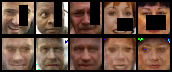
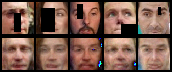

# Image retrieval

In [3]:
input_shape = (3, 32, 32)
vae = VAE(input_shape, dataset_name='faces')
trainer = Trainer(gpus=1, max_epochs=50)           # For best result you can train on 500+ epochs.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
trainer.fit(vae)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 10 M  
1 | decoder | Decoder | 6 M   


1

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

transforms_ = transforms.Compose([transforms.ToTensor()])
dataset = Faces('images/faces/', transforms_=transforms_, img_height=input_shape[1], img_width=input_shape[2])

indices = list(range(len(dataset)))
split = int(np.floor(.2 * len(dataset)))

train_indices = indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
val_indices = indices[:split]
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=1, sampler=train_sampler, drop_last=True)
val_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

In [20]:
latent_vectors = []
for image, _ in train_loader:
    image = image.to('cuda')
    mu, logvar = vae.encoder(image)
    vector = vae.sampler(mu, logvar).detach().cpu().numpy().flatten()
    latent_vectors.append(vector)

In [22]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(latent_vectors)

C:\Users\Sontref\Anaconda3\lib\site-packages\sklearn\neighbors\approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [55]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей
    image = image.view(1, *input_shape).to('cuda')
    mu, logvar = vae.encoder(image)
    code = vae.sampler(mu, logvar).detach().cpu().numpy()

    (distances,), (idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)
    neighbors = []
    for i in idx:
        neighbors.append(dataset[i][0])
    
    return distances, neighbors

In [60]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image, n_neighbors=11)
    
    plt.figure(figsize=[10,10])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

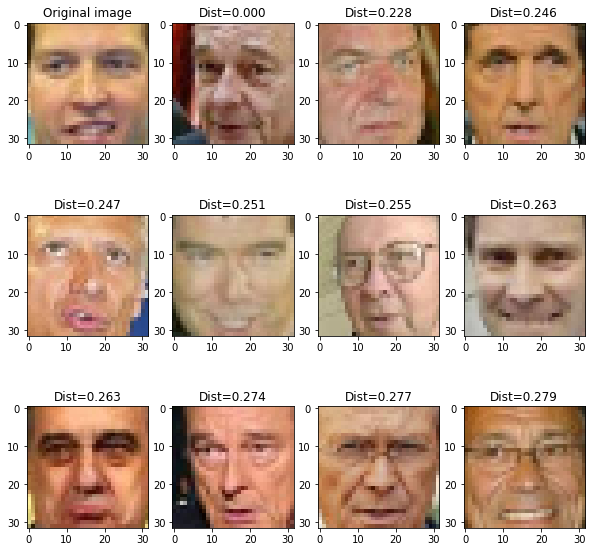

In [78]:
image = dataset[12006][0]          # change 12006 to any number to switch image. This is the best result I've found manually:D
show_similar(image)